## CSE374s_MarsRoverProject

In [41]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder


## Quick Look at the Data
There's some example data provided in the `test_dataset` folder.  This basic dataset is enough to get you up and running but if you want to hone your methods more carefully you should record some data of your own to sample various scenarios in the simulator.  

Next, read in and display a random image from the `test_dataset` folder

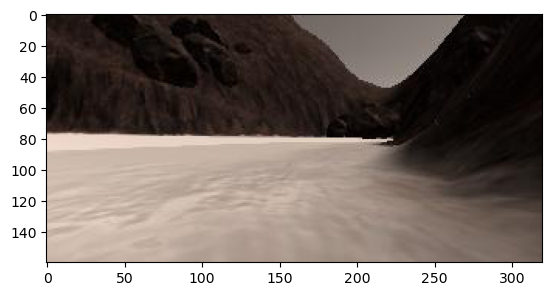

In [45]:
path = 'test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images.  You'll use the grid for perspective transform and the rock image for creating a new color selection that identifies these samples of interest. 

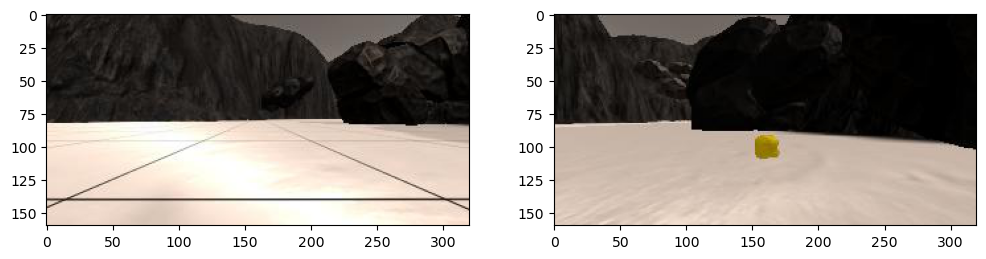

In [46]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = 'calibration_images/example_grid1.jpg'
example_rock = 'calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

## Perspective Transform

Define the perspective transform function from the lesson and test it on an image.

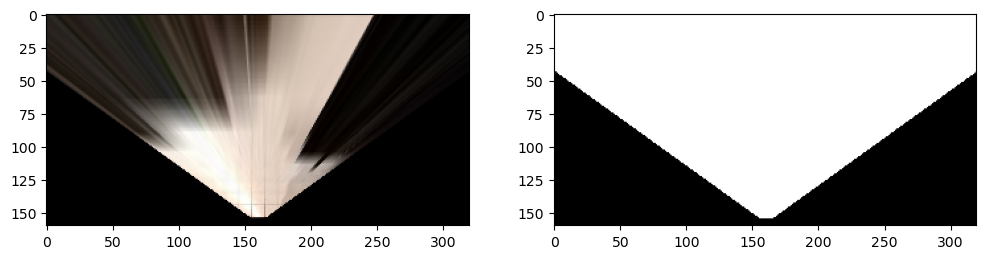

In [47]:
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    mask=cv2.warpPerspective(np.ones_like(img[:,:,0]),M,(img.shape[1], img.shape[0]))
    return warped , mask


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped , mask = perspect_transform(grid_img, source, destination)
fig=plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(mask,cmap='gray')
#scipy.misc.imsave('../output/warped_example.jpg', warped)

## Navigation Color Thresholding
Define the color thresholding function and apply it to the warped image

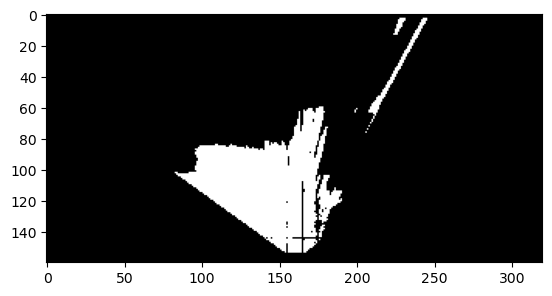

In [48]:
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(190, 190, 190)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshed = color_thresh(warped)
plt.imshow(threshed, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

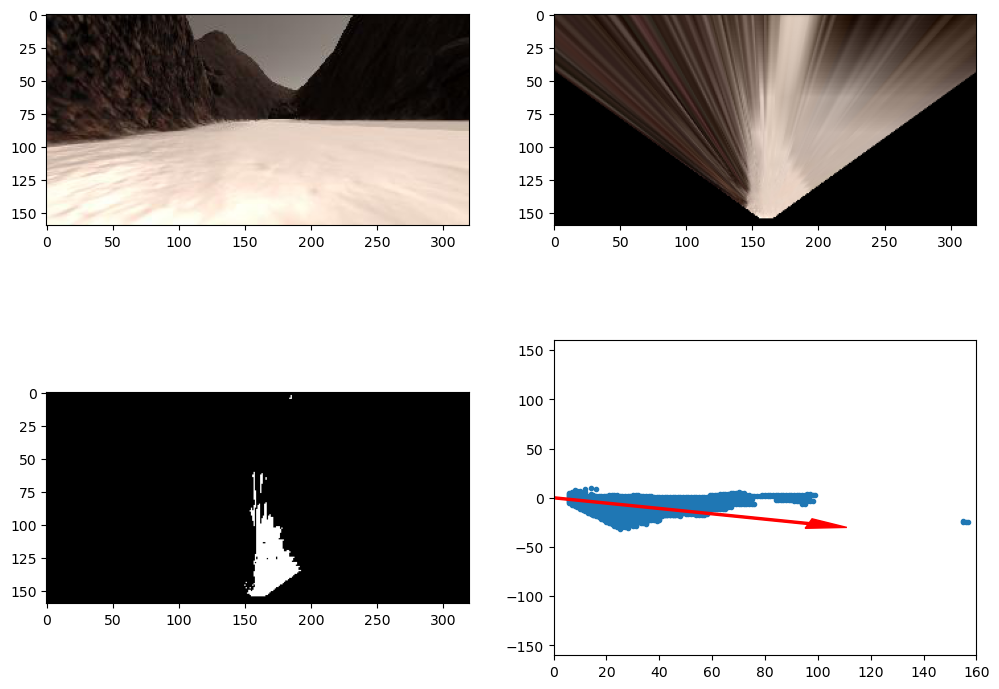

In [49]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float32)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float32)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped ,mask = perspect_transform(image, source, destination)
threshed = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)



## Rock Color Threshold

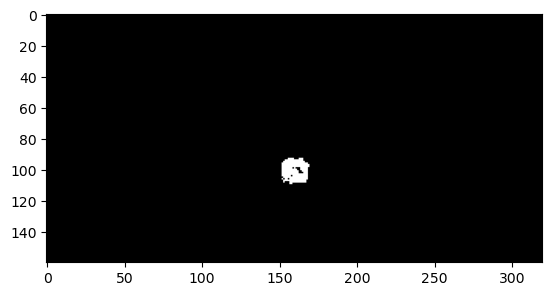

In [50]:
def find_rock(img, yellow_thresh=(110, 110, 50)):
    color_select = np.zeros_like(img[:,:,0])
    rock = (img[:,:,0] > yellow_thresh[0]) & (img[:,:,1] > yellow_thresh[1]) & (img[:,:,2] < yellow_thresh[2])
    color_select[rock] = 1
    return color_select


warped , mask = perspect_transform(rock_img, source, destination)

rock_thresh = find_rock(rock_img)

plt.imshow(rock_thresh, cmap='gray')




## Rock Coordinate Transformation

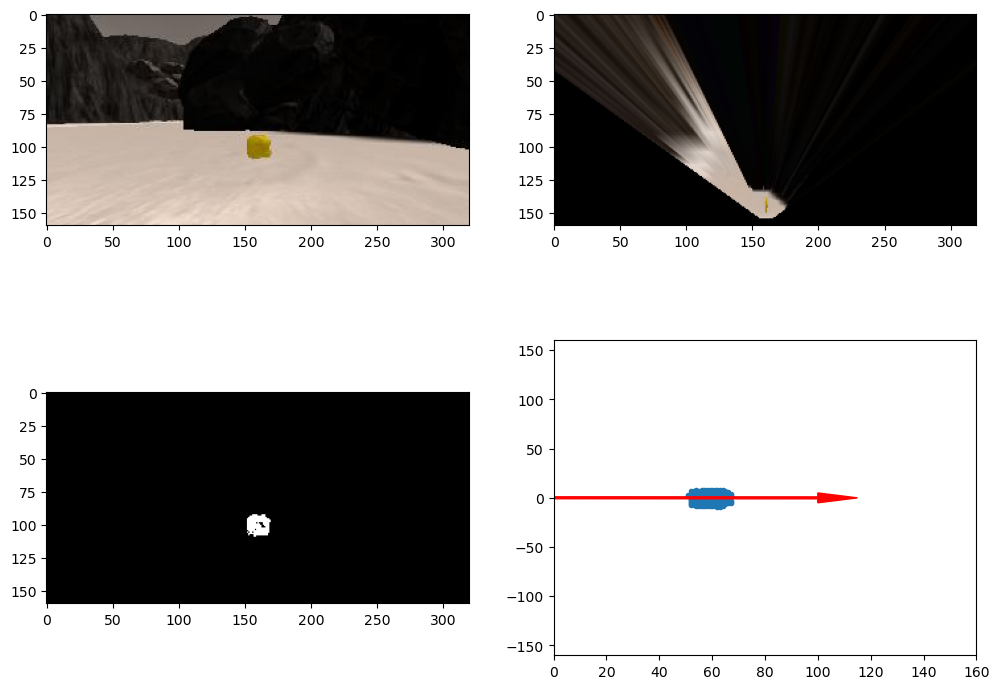

In [51]:

rock_xpix, rock_ypix = rover_coords(rock_thresh)

dist, angles = to_polar_coords(rock_xpix, rock_ypix)
mean_dir = np.mean(angles)



# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(rock_img)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(rock_thresh, cmap='gray')
plt.subplot(224)
plt.plot(rock_xpix, rock_ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

## Obstacles Color Threshold

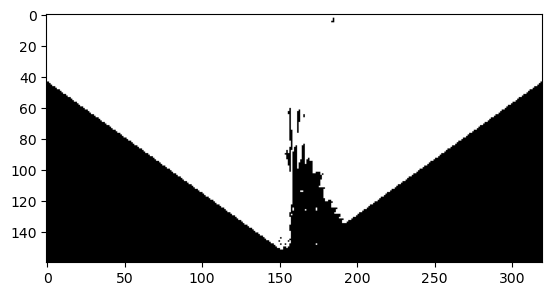

In [52]:
obstacles_img = np.absolute(np.float32(threshed)-1) * mask

plt.imshow(obstacles_img, cmap='gray')

## Rock Coordinate Transformation

(0.0, 160.0)

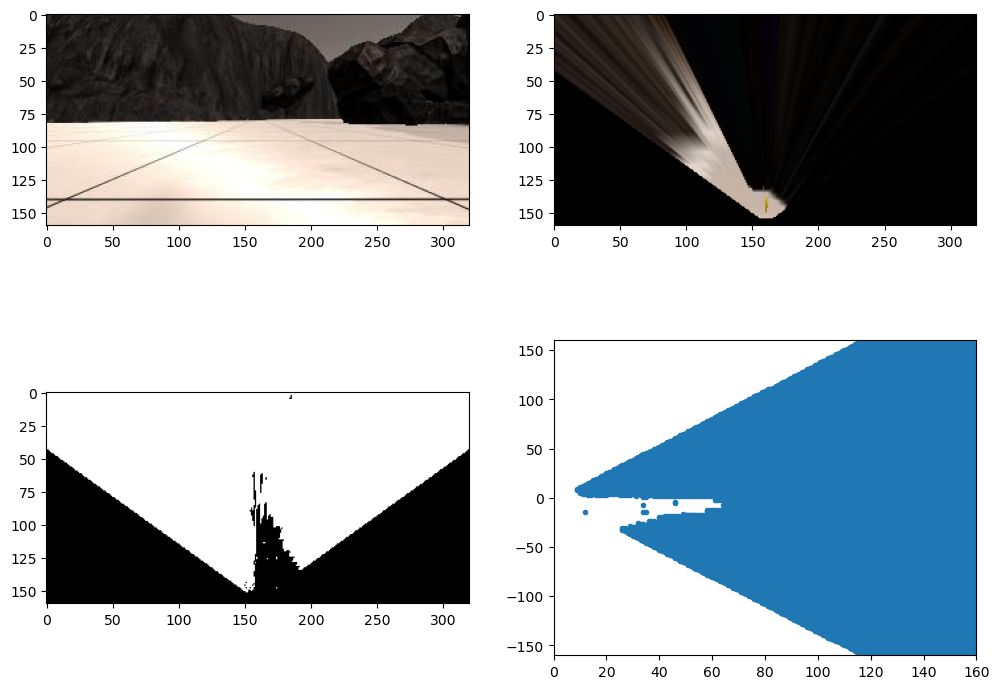

In [53]:

obs_xpix, obs_ypix = rover_coords(obstacles_img)

dist, angles = to_polar_coords(obs_xpix, obs_ypix)
mean_dir = np.mean(angles)



# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(grid_img)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(obstacles_img, cmap='gray')
plt.subplot(224)
plt.plot(obs_xpix, obs_ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)


In [54]:
#Import pandas and read in csv file as a dataframe
import pandas as pd
df = pd.read_csv('robot_log.csv', delimiter = ';', decimal='.')
csv_img_list = df["Path"].tolist() #Create list of image pathnames
#Read in ground truth map and create a J-channel image with it
ground_truth = mpimg.imread('calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0,ground_truth*255,ground_truth*0)).astype(np.float32)

#Creating a class to be the data container
#Will read in saved data from csv file and populate this object
class Databucket():
    def __init__(self):
        self.image = csv_img_list
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 #This will be a running index
        self.worldmap = np.zeros((200,200,3)).astype(np.float32)
        self.ground_truth = ground_truth_3d #Ground truth worldmap

#Instantiate a Databucket() object to refer in the process_image() function below
data = Databucket()
        

In [55]:
#Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    # 4) Convert thresholded image pixel values to rover-centric coords
    # 5) Convert rover-centric pixel values to world coords
    # 6) Update worldmap (to be displayed on right side of screen)
        # Example: data.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          data.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          data.worldmap[navigable_y_world, navigable_x_world, 2] += 1
        
            # 2) Apply perspective transform
    warped , mask = perspect_transform(img,source,destination)
    
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    #terrain
    terrain_img = color_thresh(warped, rgb_thresh=(160, 160, 160))
    #rock samples
    rock_img = find_rock(warped)
    #obstacles
    obstacles_img = np.absolute(np.float32(terrain_img)-1) * mask 
    
    #4) Update Rover.vision_image (this will be displayed on left side of screen)
        # Example: Rover.vision_image[:,:,0] = obstacle color-thresholded binary image
        #          Rover.vision_image[:,:,1] = rock_sample color-thresholded binary image
        #          Rover.vision_image[:,:,2] = navigable terrain color-thresholded binary image
    



    xpix, ypix = rover_coords(terrain_img)
    rock_xpix, rock_ypix = rover_coords(rock_img)
    obs_xpix, obs_ypix = rover_coords(obstacles_img)
    
    # 5) Convert rover-centric pixel values to world coords
    
    world_size = data.worldmap.shape[0]
    scale = 2 * dst_size
    yaw = data.yaw
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    
    x_world, y_world = pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale)
    rock_x_world, rock_y_world = pix_to_world(rock_xpix, rock_ypix, xpos, ypos, yaw, world_size, scale)
    obs_x_world, obs_y_world = pix_to_world(obs_xpix, obs_ypix, xpos, ypos, yaw, world_size, scale)
    
    # 7) Update Rover worldmap (to be displayed on right side of screen)
        # Example: Rover.worldmap[obstacle_y_world, obstacle_x_world, 0] += 1
        #          Rover.worldmap[rock_y_world, rock_x_world, 1] += 1
        #          Rover.worldmap[navigable_y_world, navigable_x_world, 2] += 1

    data.worldmap[obs_y_world, obs_x_world, 0] = 255
    
    data.worldmap[y_world, x_world, 2] = 255
        
    # remove overlap mesurements
    nav_pix = Rover.worldmap[:, :, 2] > 0
    data.worldmap[nav_pix, 0] = 0
    # clip to avoid overflow
    data.worldmap = np.clip(Rover.worldmap, 0, 255)
        
    if rock_map.any():
        rock_xpix, rock_ypix = rover_coords(rock_img)
        rock_x_world, rock_y_world = pix_to_world(rock_xpix, rock_ypix, xpos, ypos, yaw, world_size, scale)
        data.worldmap[rock_y_world, rock_x_world, 1] = 255
        

   
    # 7) Make a mosaic image
    
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2,3))
    
    output_image [0:img.shape[0], 0:img.shape[1]] = img
    
    # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]: ] = warped
    
    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
    
    # Flip map overlay so y-axis points upward and add to output_image
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)
    
    # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!",(20,20),
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255,255,255),1)
    if data.count < len(data.image) -1:
        data.count += 1 #Keep track of the index in the Databucket()
        
    return output_image
    

## Make a video from processed image data

In [56]:
# Import everything needed to edit/save/watch video
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip

# Define pathname to save the output video
output = 'output/test_mapping.mp4'
clip = ImageSequenceClip(data.image, fps=60)

new_clip = clip.fl_image(process_image)
%time new_clip.write_videofile(output, audio=False)

ValueError: operands could not be broadcast together with shapes (3351,) (1250,) 

# This next cell should function as an inline video player


In [ ]:
from IPython.display import HTML
HTML("""
<video width= "960" height = "540" controls>
   <source src = "{0}">
</video>
""".format(output))